# Index

1. [Loading Data](#data)
    1. [Boston House Prices Data Summary](#boston)
2. [EDA](#eda)
    1. [Initial analysis](#ia)
    2. [Possible Maximum Quantization Error](#mqe)
3. [Ordinary Least Squares](#ols)
    1. [Model 1: OLS on RM](#rm)
    2. [Model 2: Ridge on Log of LSTAT Column](#lstat)
4. [Other Single Column Regressions](#pr)
    1. [Model 3: 5th Order Polynomial Regression on LSTAT](#rls)
    2. [Model 4: Random Sample Consensus](#rsc)

# 1. Loading Data
<a id = "data"></a>

In [134]:
#Standard Libraries
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [135]:
from sklearn.datasets import load_boston
boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

#### <center> Boston house prices dataset</center> <a id = "boston"></a> 
|Column| Description |
| --- | --- |
|<strong>CRIM</strong>|per capita crime rate by town <br>
|<strong>ZN</strong>|proportion of residential land zoned for lots over 25,000 sq.ft.<br>
|<strong>INDUS</strong>|proportion of non-retail business acres per town<br>
|<strong>CHAS</strong>|Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)<br>
|<strong>NOX</strong>|nitric oxides concentration (parts per 10 million)<br>
|<strong>RM</strong>|average number of rooms per dwelling<br>
|<strong>AGE</strong>|proportion of owner-occupied units built prior to 1940<br>
|<strong>DIS</strong>|weighted distances to five Boston employment centres<br>
|<strong>RAD</strong>|index of accessibility to radial highways<br>
|<strong>TAX</strong>|full-value property-tax rate per \$10,000<br>
|<strong>PTRATIO</strong>|pupil-teacher ratio by town<br>
|<strong>B</strong>|1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
|<strong>LSTAT</strong>|\% lower status of the population<br>
|<strong>MEDV</strong>|Median value of owner-occupied homes in \$1000's<br>

# 2. EDA <a id = "eda"></a>

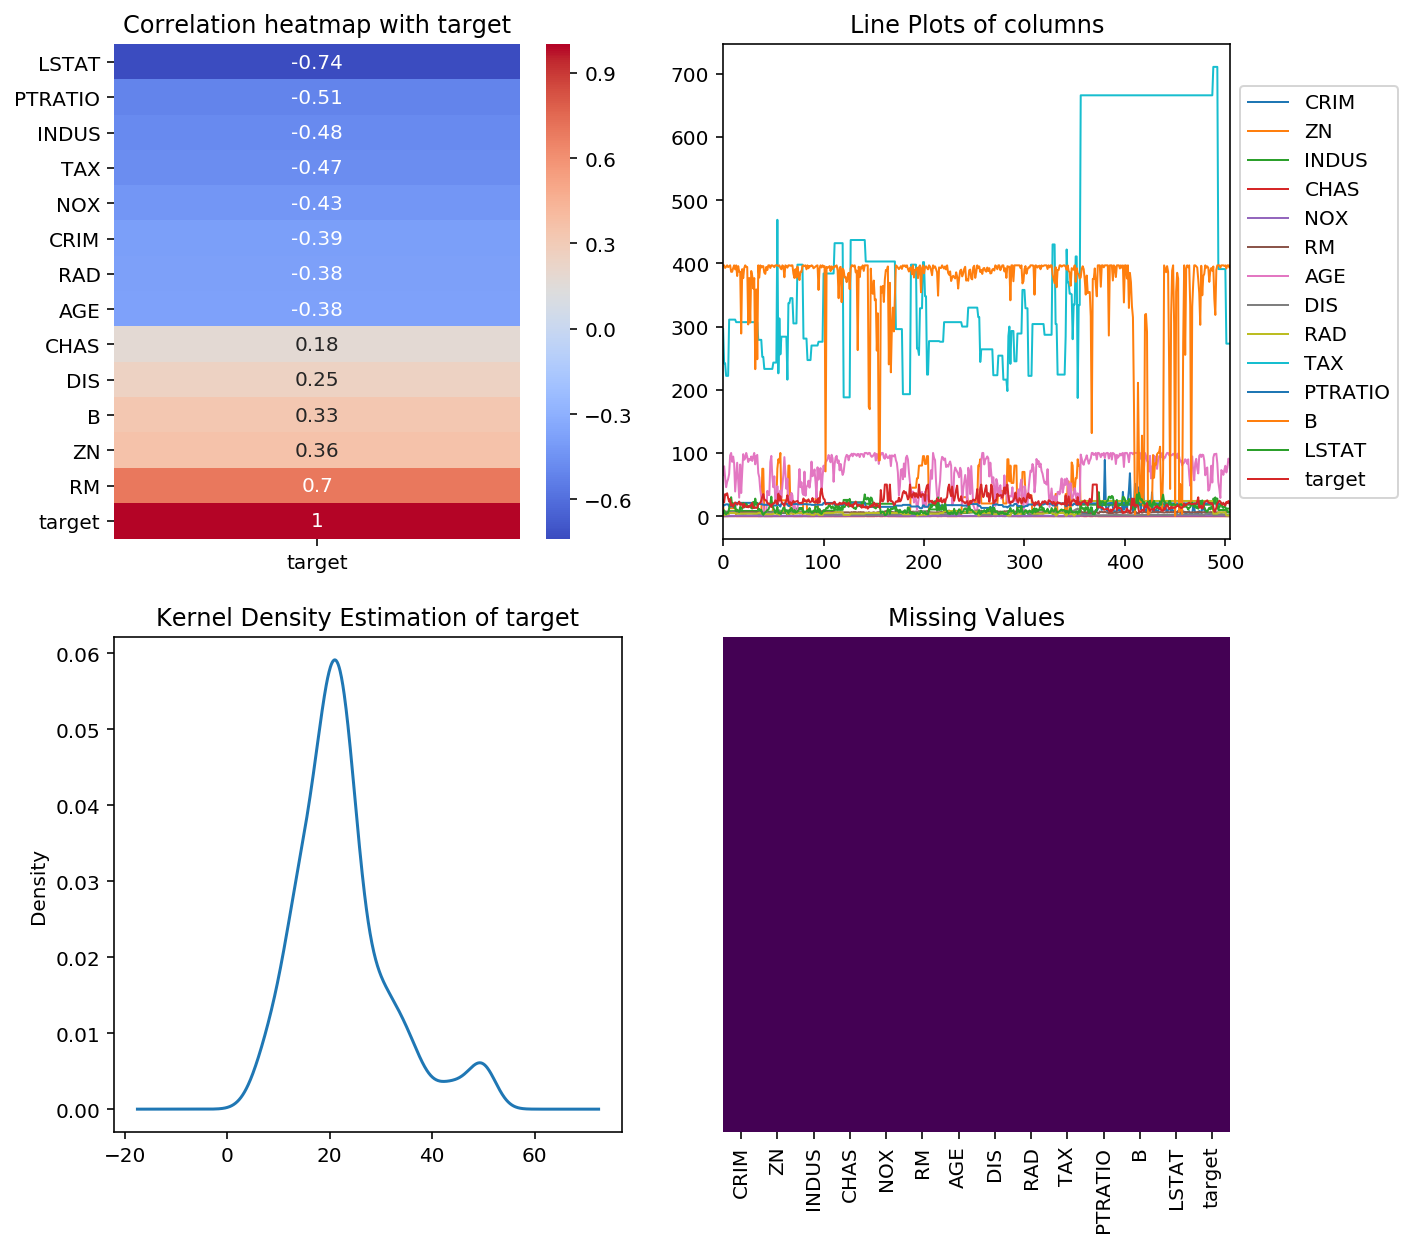

In [136]:
df = X.copy()
df["target"] = y

figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0,0].set_title("Correlation heatmap with target");
sns.heatmap(df.corr()[['target']].sort_values("target"), annot=True, cmap='coolwarm', ax = ax[0,0]);

ax[0,1].set_title("Line Plots of columns");
df.plot(lw = 1, ax = ax[0,1]);
ax[0,1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ax[1,0].set_title("Kernel Density Estimation of target");
df["target"].plot.kde(ax = ax[1,0],);

ax[1,1].set_title("Missing Values");
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis', ax = ax[1,1]);

In [137]:
print("{}% of dataframe with target over 50".format(100 * len(df[df["target"] > 50])/len(df)))
print("{}% of dataframe with target equal to 50".format(round(100 * len(df[df["target"] == 50])/len(df),2)))

0.0% of dataframe with target over 50
3.16% of dataframe with target equal to 50


<div class="alert alert-block alert-danger"><a id = "mqe"></a> 
    <strong>Possible Maximum Quantization Error</strong>
<br><br>
Since the targets are roughly normally distributed, but have a cut off max at 50, these data are a result of a possible Maximum Quantization Error and will be dropped. Given that these data only occupy ~3% of the dataframe, the result should be negligible.
</div>

In [138]:
#Cut out MQ error.
df = df[df["target"] < 50]

#### 2B. Initial Analysis <a id = "ia"></a>

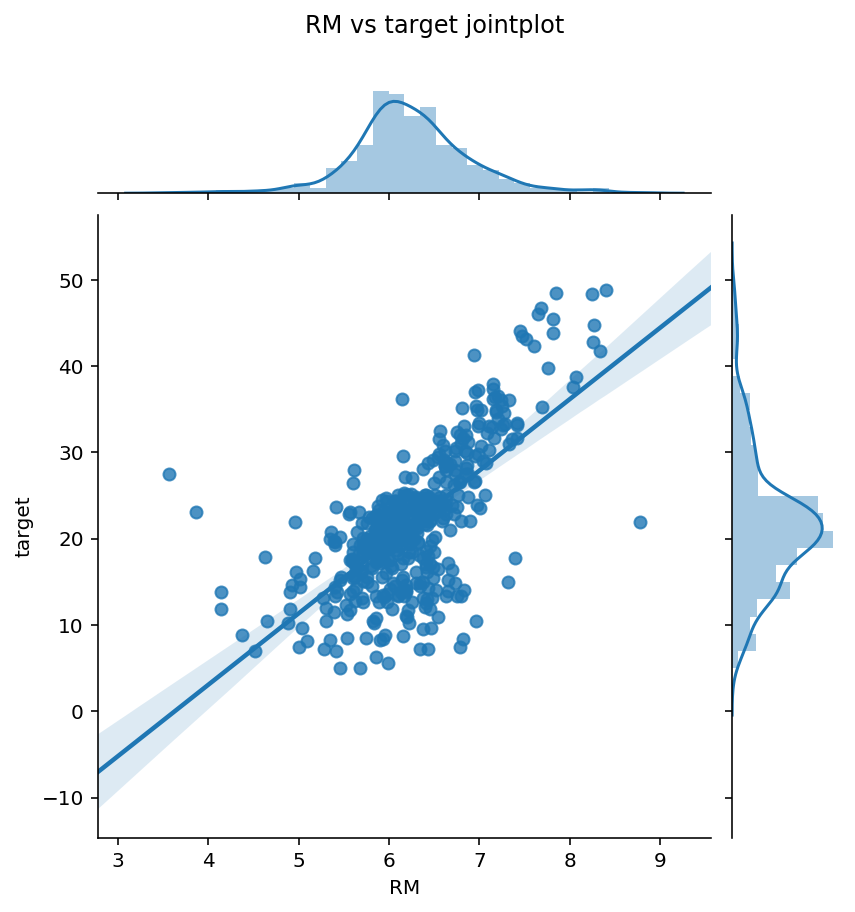

In [139]:
sns.jointplot("RM", "target", data=df, kind='reg');
plt.suptitle("RM vs target jointplot", y = 1.05);

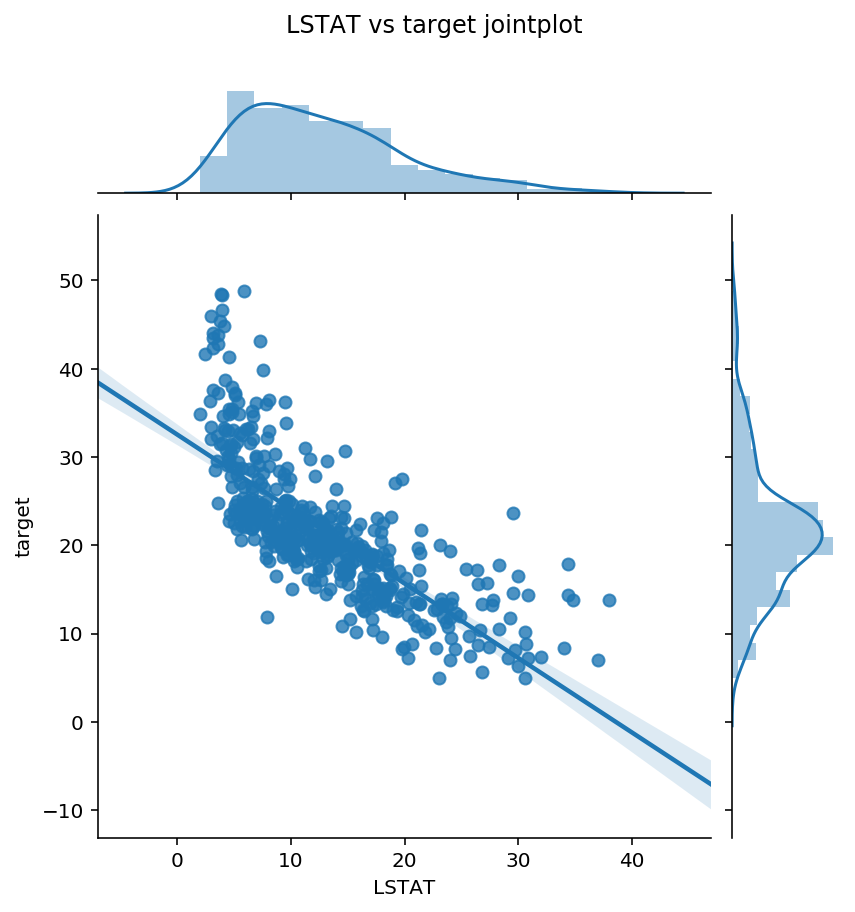

In [140]:
sns.jointplot("LSTAT", "target", data=df, kind='reg');
plt.suptitle("LSTAT vs target jointplot", y = 1.05);

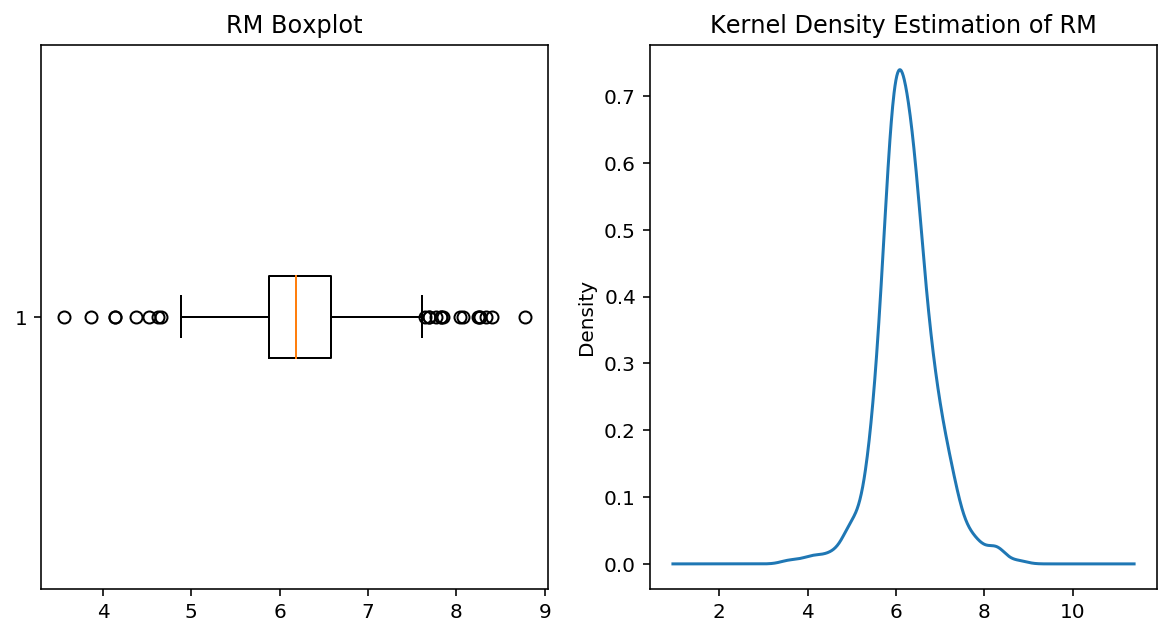

In [141]:
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5));
ax[0].set_title('RM Boxplot');
ax[0].boxplot(df["RM"], vert=False);

ax[1].set_title("Kernel Density Estimation of RM");
df["RM"].plot.kde(ax = ax[1]);

In [142]:
df[(df["RM"] < 4) | (df["RM"] > 8.75)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
364,3.47428,0.0,18.1,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5
367,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1


<div class="alert alert-block alert-info">
    <strong>Removing Outliers</strong>
<br><br>
Given that RM homes with less than 4 rooms or greater than 8.75 rooms are rare, we will also remove these values from the dataframe. 
</div>

In [143]:
print("Original length of dataset: {}".format(len(X)))
print("Current length of dataset: {}".format(len(df[(df["RM"] >= 4) & (df["RM"] <= 8.75)])))

Original length of dataset: 506
Current length of dataset: 487


In [144]:
df = df[(df["RM"] >= 4) & (df["RM"] <= 8.75)]

# 3. Ordinary Least Squares <a id = "rm"></a>

#### 3A. Model 1: OLS on RM Column<a id = "rm"></a>

In [145]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Define Range and Domain

X1 = df[["RM"]]
y1 = df["target"]

#Train/Test/Split Range and Domain

X_train, X_test, y_train, y_test = train_test_split(X1,y1, random_state = 88)

#Instantiate model 

lr = LinearRegression()

#Test Cross Validation Scores
cross_val_score(lr,X_train, y_train, cv = 5)

array([0.4408982 , 0.63681981, 0.45081936, 0.54587115, 0.31592723])

In [146]:
#Fit Model
lr.fit(X_train,y_train)
model_1 = lr.score(X_test,y_test)

#Test Model
pred = lr.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred
yhat = X_test*lr.coef_[0]+lr.intercept_

print("R^2 of model 1: {}".format(round(model_1,3)))

R^2 of model 1: 0.621


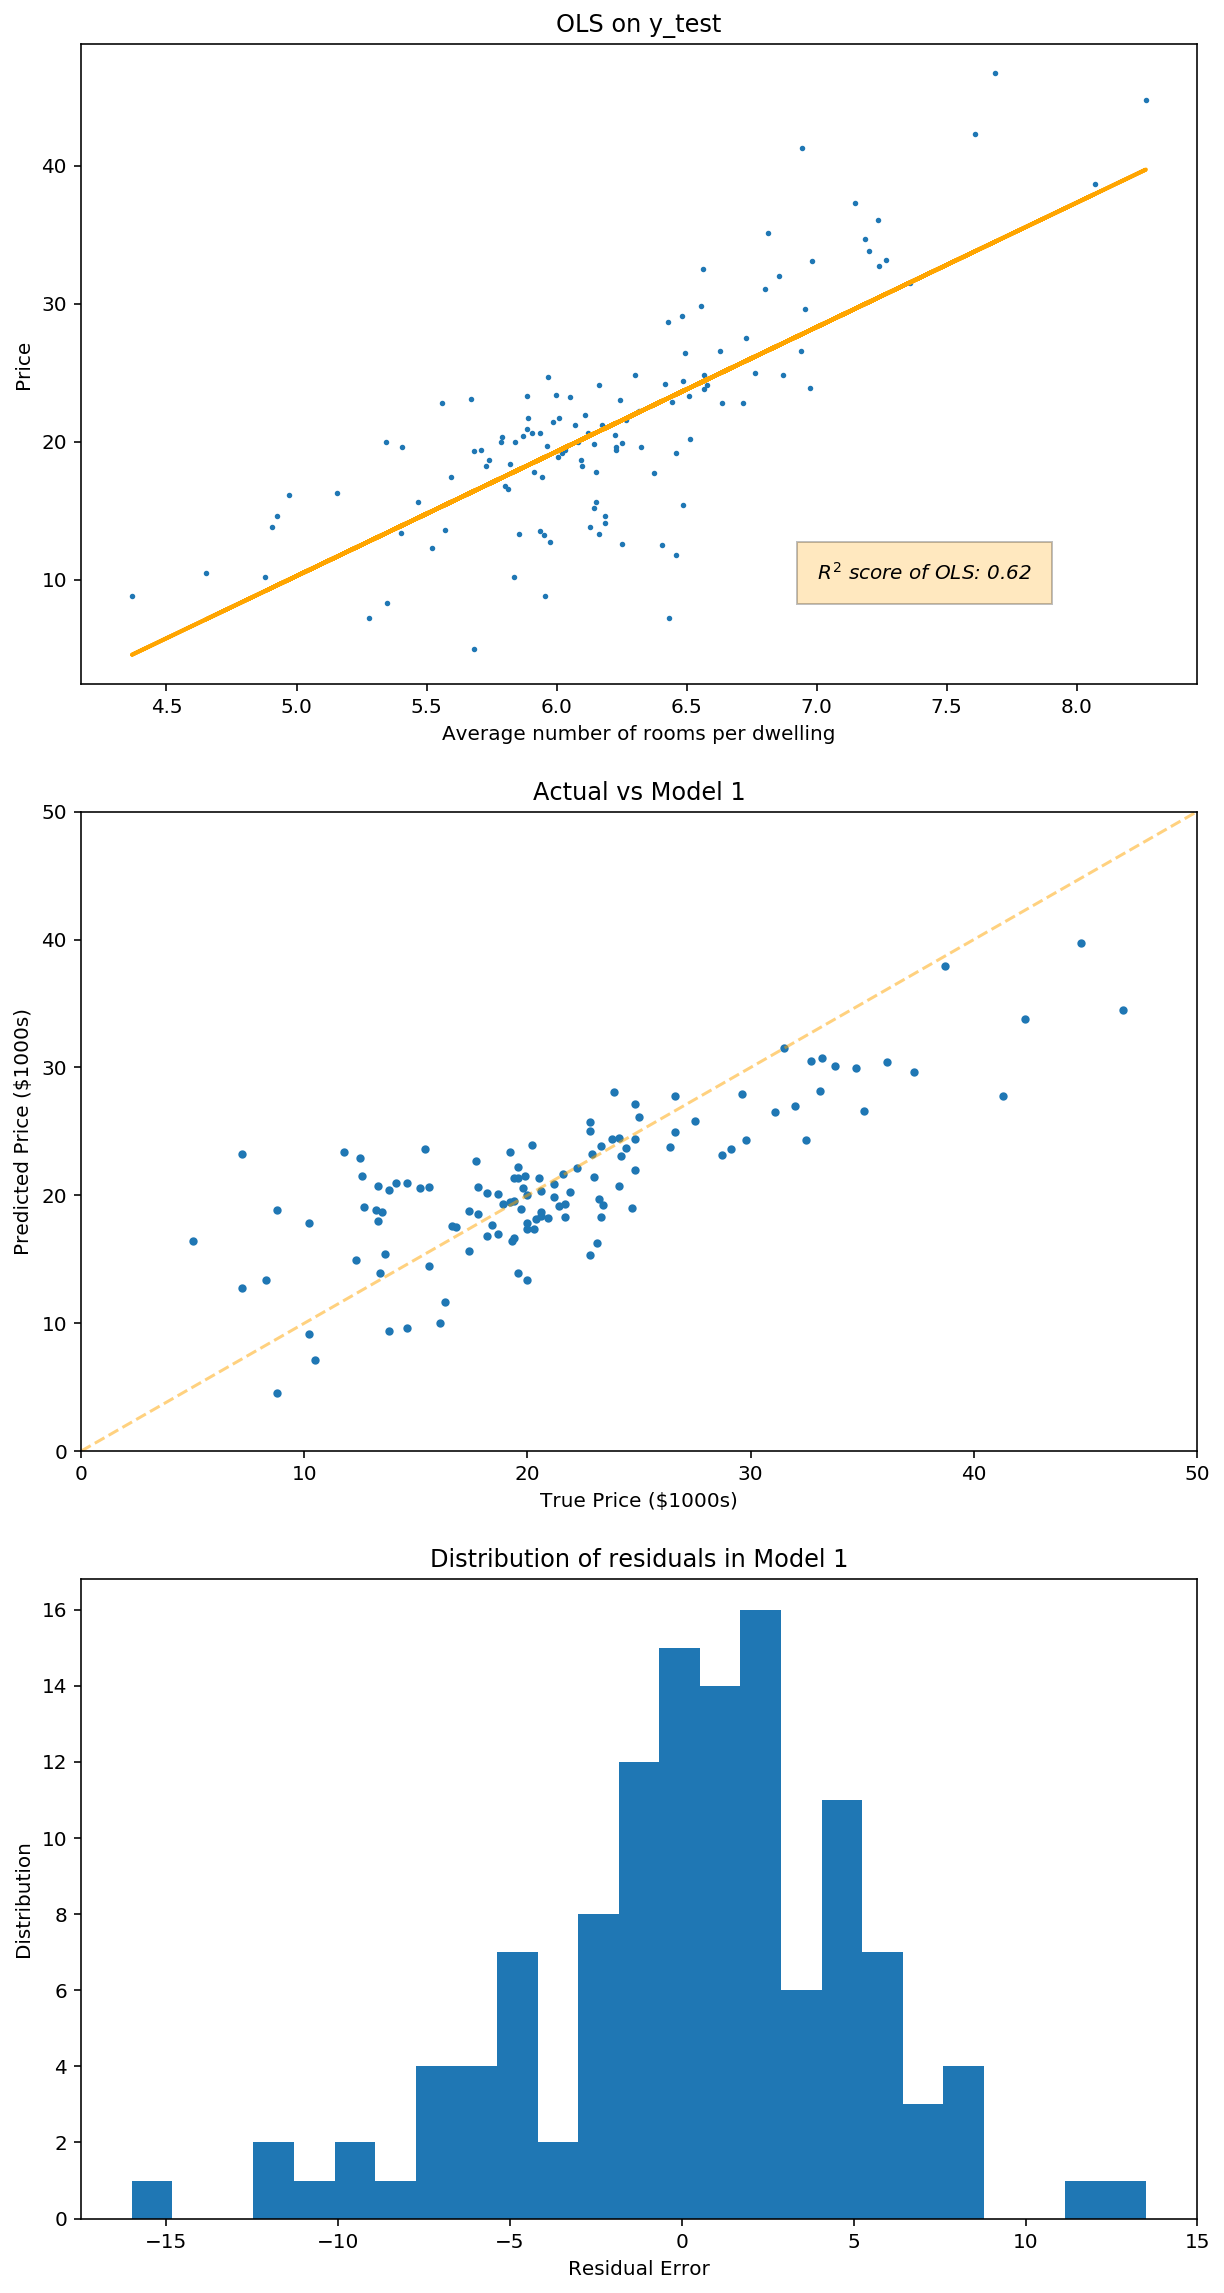

In [148]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(X_test,y_test, s = 3);
ax[0].plot(X_test,yhat, lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Average number of rooms per dwelling");
ax[0].set_ylabel('Price');
ax[0].set_title("OLS on y_test");
ax[0].text(7, 10, '${}${}{}'.format('R^2'," score of OLS: ",str(round(r2_score(y_test,pred),2))), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

# ax[0].legend(('OLS', 'Test Values'), loc='lower left', bbox_to_anchor=(1, 0))


ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Actual vs Model 1");


ax[2].hist(residuals, bins = 25);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals in Model 1");

#### 3B. Model 2: Ridge on Log of LSTAT Column<a id = "lstat"></a>

In [149]:
#Define Range and Domain

X2 = np.log(df[["LSTAT"]])
y2 = df["target"]

#Train/Test/Split Range and Domain

X_train, X_test, y_train, y_test = train_test_split(X2,y2, random_state = 88)

#Instantiate model 

ridge = RidgeCV()

#Test Cross Validation Scores
cross_val_score(ridge,X_train, y_train, cv = 5)

array([0.60087178, 0.74554662, 0.5473587 , 0.62139172, 0.66308177])

In [151]:
#Fit Model
ridge.fit(X_train,y_train)
model_2 = ridge.score(X_test,y_test)

#Test Model
pred = ridge.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred
yhat = X_test*ridge.coef_[0]+ridge.intercept_

print("R^2 of model 2: {}".format(round(model_2,3)))

R^2 of model 2: 0.737


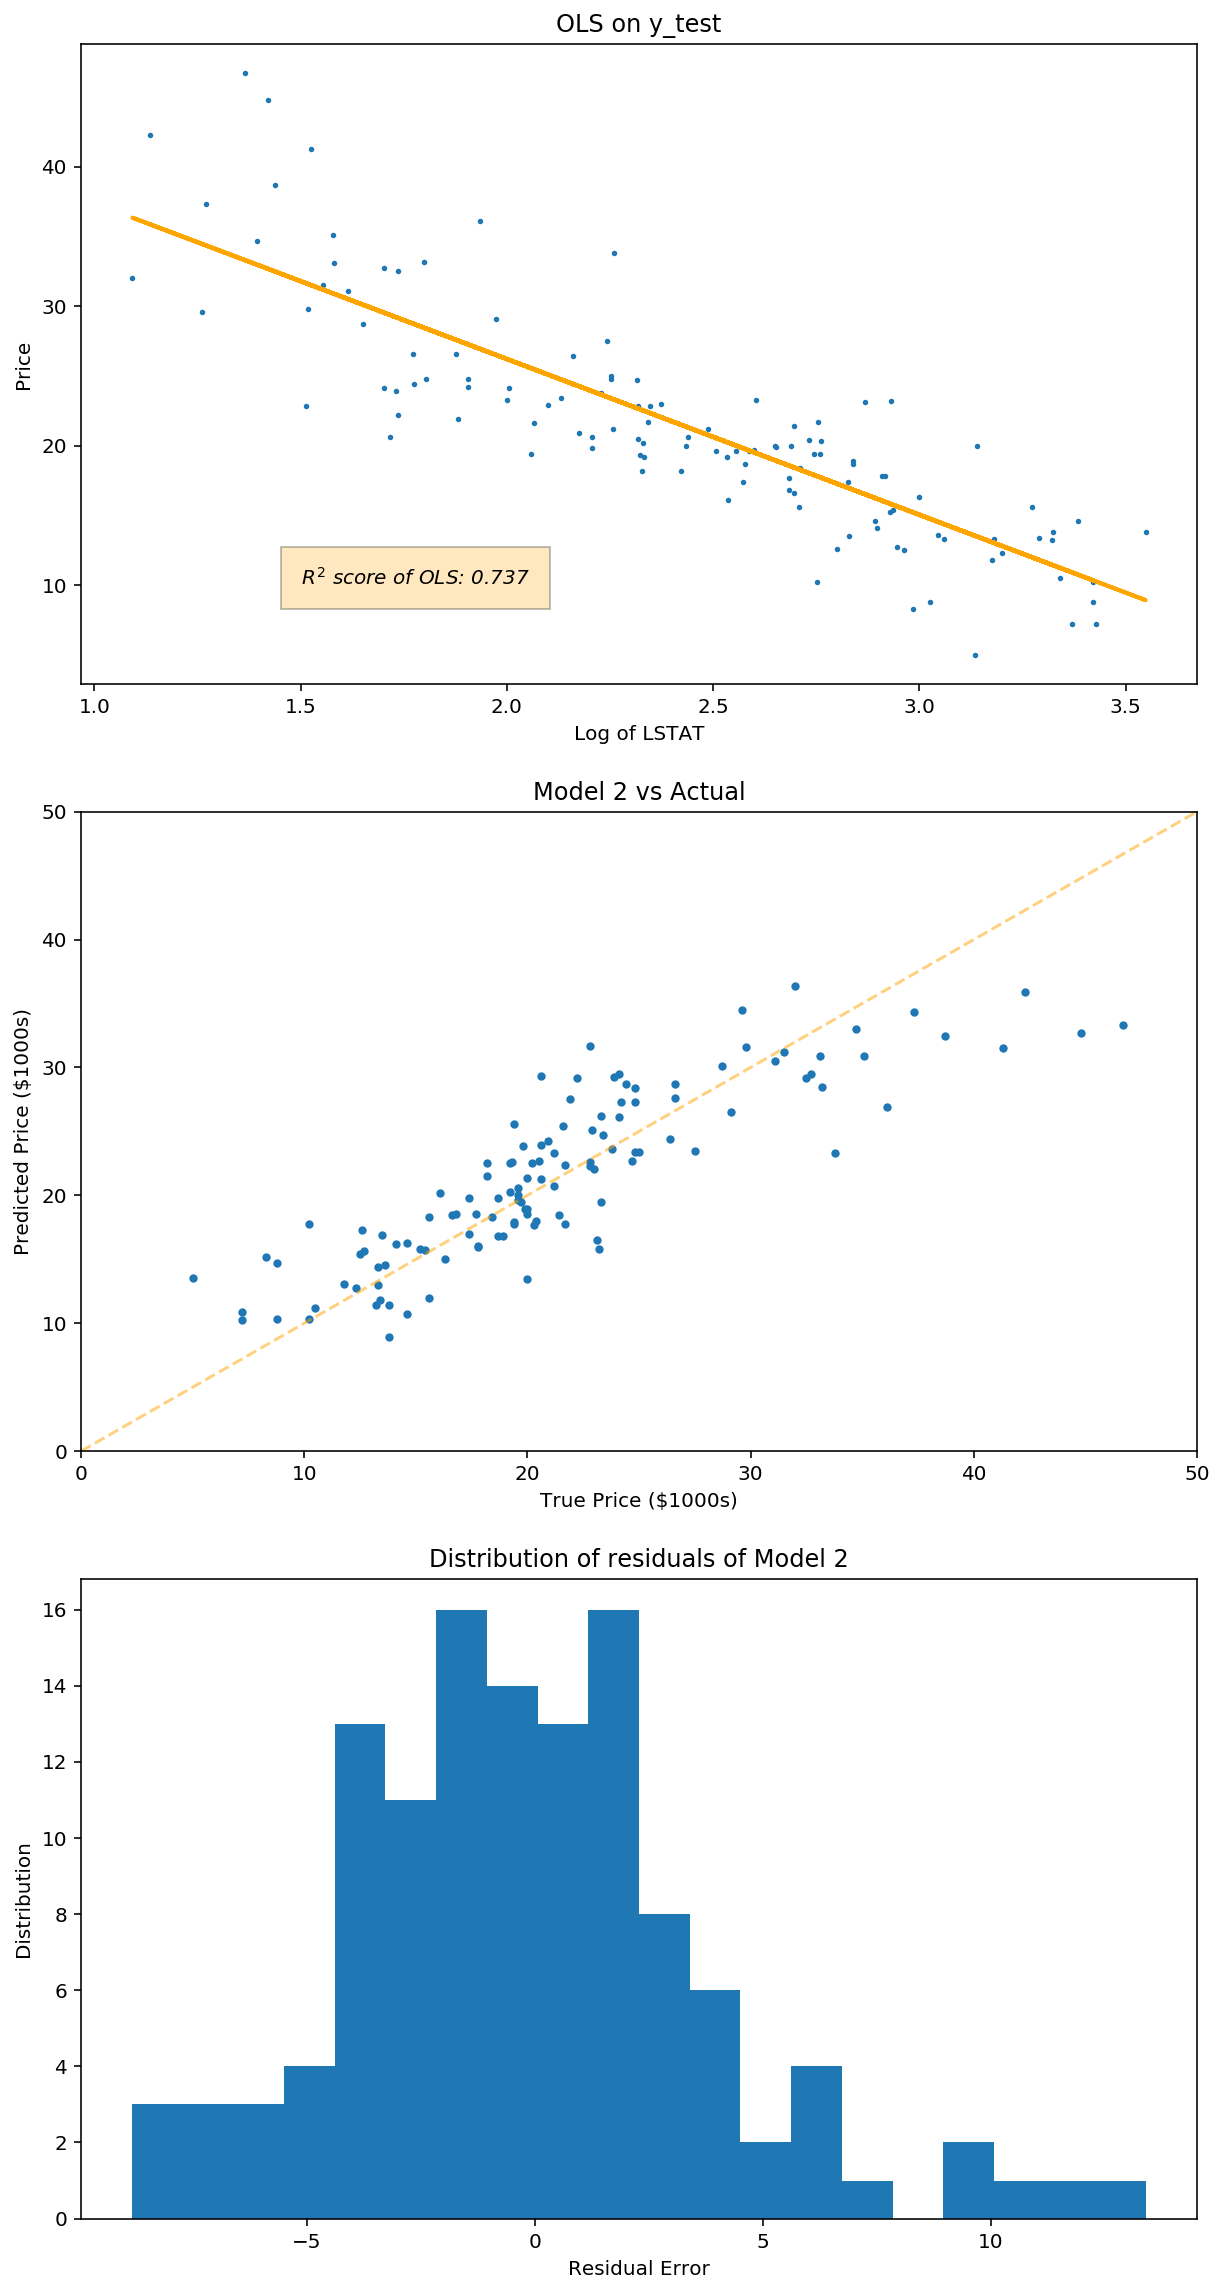

In [152]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(X_test,y_test, s = 3);
ax[0].plot(X_test,yhat, lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Log of LSTAT");
ax[0].set_ylabel('Price');
ax[0].set_title("OLS on y_test");
ax[0].text(1.5, 10, '${}${}{}'.format('R^2'," score of OLS: ",str(round(r2_score(y_test,pred),3))), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Model 2 vs Actual");

ax[2].hist(residuals, bins = 20);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals of Model 2");

# 4. Other Single Column Regressions <a id = "pm"></a>

In [153]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#### 4A. Model 3: 5th Order Polynomial Regression on LSTAT<a id = "rls"></a>

In [162]:
#Define Range and Domain

X3 = np.log(df[["LSTAT"]])
y3 = df["target"]

# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=5,
                          interaction_only=False,
                          include_bias=True)

X_overfit = pd.DataFrame(poly.fit_transform(X3),columns=poly.get_feature_names(X3.columns))

#Train/Test/Split Range and Domain
X_train, X_test, y_train, y_test = train_test_split(X_overfit,y3, random_state = 88)

#Instantiate model 

lr = LinearRegression()
ridge = RidgeCV()

print("LR Cross Val Score: ", cross_val_score(lr, X_train,y_train, cv = 5).mean())
print("Ridge Cross Val Score: ", cross_val_score(ridge, X_train,y_train, cv = 5).mean())

LR Cross Val Score:  0.6390267826175717
Ridge Cross Val Score:  0.6187405544228045


In [163]:
#Fit Model
lr.fit(X_train,y_train)
model_3 = lr.score(X_test,y_test)

#Test Model
pred = lr.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred

print("R^2 of model 3: {}".format(round(model_3,3)))

R^2 of model 3: 0.753


In [165]:
ridge = RidgeCV().fit(X_train,y_train)
reg = RANSACRegressor(random_state = 88).fit(X_train,y_train)
thel = TheilSenRegressor(random_state = 88).fit(X_train,y_train)
huber = HuberRegressor(max_iter=1000,).fit(X_train,y_train)

print(ridge.score(X_test,y_test), reg.score(X_test,y_test),thel.score(X_test,y_test),huber.score(X_test,y_test))

0.7426296736131026 0.6552836808142557 0.7479520454986509 0.7335655699560746


In [156]:
#Polynomial Plot Setup

plot = X_test.copy()
plot = plot.assign(pred=pd.Series(pred).values)
plot = plot.assign(actual=pd.Series(y_test).values)
plot = plot.sort_values("LSTAT")

coef = list(lr.coef_)
coef[0] = lr.intercept_

def polyplot(x):

    o = len(coef)
    y = 0
    for i in range(o):
        y += coef[i]*x**i
    return y

x = np.linspace(plot.iloc[0,1], plot.iloc[len(plot) - 1,1], 100)

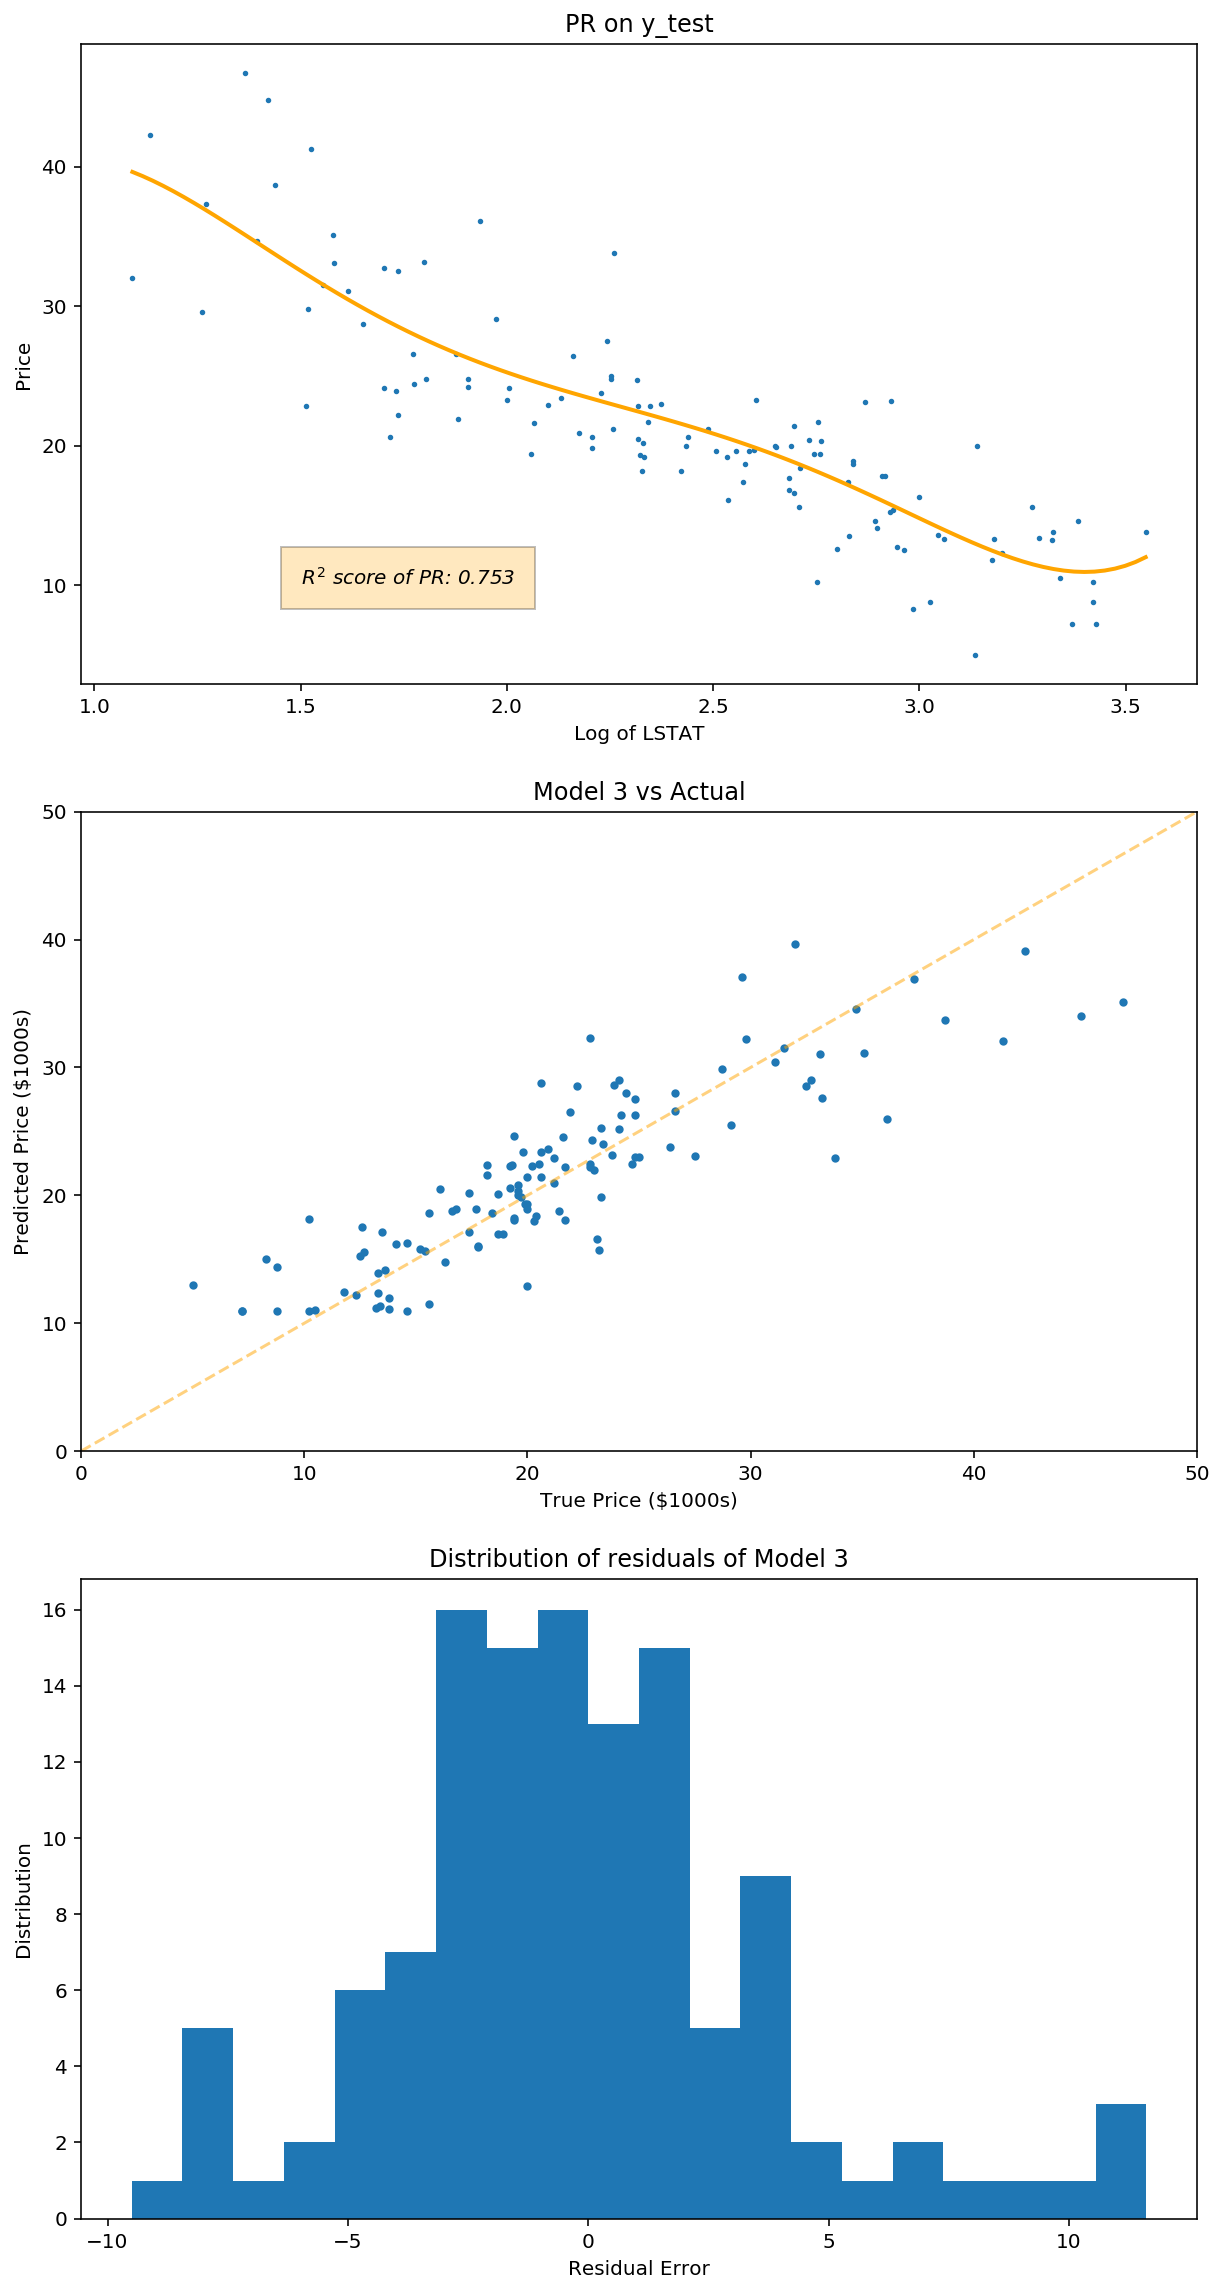

In [157]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(plot["LSTAT"],plot["actual"], s = 3);
ax[0].plot(x, polyplot(x), lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Log of LSTAT");
ax[0].set_ylabel('Price');
ax[0].set_title("PR on y_test");
ax[0].text(1.5, 10, '${}${}{}'.format('R^2'," score of PR: ",str(round(r2_score(y_test,pred),3))), style='italic',
         bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Model 3 vs Actual");

ax[2].hist(residuals, bins = 20);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals of Model 3");

#### 4B. Model 4: Random Sample Consensus <a id = "rsc"></a>

In [127]:
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor

In [161]:
#Define Range and Domain

X4 = np.log(df[["LSTAT"]])
y4 = df["target"]

#Train/Test/Split Range and Domain
X_train, X_test, y_train, y_test = train_test_split(X4,y4, random_state = 88)

#Instantiate models 

reg = RANSACRegressor(random_state = 88).fit(X_train,y_train)
thel = TheilSenRegressor(random_state = 88).fit(X_train,y_train)
huber = HuberRegressor(max_iter=1000,).fit(X_train,y_train)

print(reg.score(X_test,y_test),thel.score(X_test,y_test),huber.score(X_test,y_test))

# print(cross_val_score(reg, X_train,y_train, cv = 5).mean())
# print(cross_val_score(thel, X_train,y_train, cv = 5).mean())
# print(cross_val_score(huber, X_train,y_train, cv = 5).mean())

0.6714091141422639 0.7214490705990644 0.7314944338259546


In [129]:
#Fit Model
huber.fit(X_train,y_train)
model_3 = lr.score(X_test,y_test)

#Test Model
pred = lr.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred

print("R^2 of model 3: {}".format(round(model_3,3)))

R^2 of model 3: 0.737


In [111]:
X = df[["PTRATIO"]]
y = df["target"]

X = sm.add_constant(X);

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

NameError: name 'sm' is not defined

In [ ]:
model.params

In [ ]:
plt.scatter(X,y, s = 1)
yhat = X*model.params
fig = plt.plot(X,yhat, lw=2, c='orange', label ='regression line')
plt.xlabel('Square ft',fontsize=15)
plt.ylabel('Price ($)',fontsize=15)
plt.show()

In [81]:
np.arange(n)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])